In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import scipy.misc as misc
from numba import njit, jit
import sys
import legendre
from joblib import Parallel, delayed
from scipy.interpolate import interp2d


In [2]:
def kop(pot, l, a, D, noise, guess_size):
    def phi(x):
        if noise == "d":
            return np.cosh(x) - 1
        elif noise == "e":
            return x**2 / (2 * (1 - x**2))

    kmax = 1e-10
    Vmax = pot.max()
    while Vmax > D / 2 * kmax + l * phi(a * kmax) / kmax:
        kmax+=1e-6

    # print(l, a, D, noise)

    optk = []
    if pot[0] == 0:
        optk.append(0)
        V = pot[1:]
    else:
        V = pot
    

    K = np.linspace(start=1e-8, stop=1/a - 1e-7, num=guess_size)
    
    for x in V:
        aux = []
        if noise=="e":
            K = np.linspace(start=1e-10, stop=1/a - 1e-10, num=guess_size)
        elif noise=="d":
            if x == 0:
                K = np.zeros(guess_size)
            else:
                K = np.linspace(start=1e-15, stop=kmax , num=guess_size)
        
        for k in K:
            if x == 0:
                aux.append(0)
            else:
                p = D / 2 * k + l * phi(a * k) / k
                aux.append(np.abs(x - p))
            
        
        
        optimal_k = np.min(aux)
        
        ind = np.where(aux == optimal_k)[0]
        optk.append(K[ind][0])
    
    return optk

def integral(q, a, l, D, noise):
    def dV(q):
        return q ** 3 - q
    def ddV(q):
        return 3 * q ** 2 - 1
    
    dPot = dV(q)
    ddPot = ddV(q)
    # dPot = dPot[np.where(ddPot >= 0)]
    # ddPot = ddPot[np.where(ddPot >= 0)]

    #print(dPot.max(), np.cosh(1)*1/a, a)
    kopt = np.array(kop(dPot, l , a, D, noise, 10000))


    return np.trapz(kopt, q)#[np.where(ddPot >= 0)]) 

In [3]:
q = np.linspace(-1, 0, 10)

a = 0.1
l = 1e-6

print(integral(q, a, l, 1, "d"), 2 * 1/4 * 1 /(1 + a**2 * l), 2 * 1 / 4  / (1 + a ** 2 * l))

0.4938329161567008 0.4999999950000001 0.4999999950000001


In [4]:
N = 20



q = np.linspace(-1, 0, 10)



a1 = np.logspace(-1, 4, base=10, num=N)
a2 = np.logspace(0, 4, base=10, num=N)

l = np.logspace(-6, 0, base=10, num=N)

res_e = np.zeros((N, N))
res_d = np.zeros((N, N))

S_01 = np.zeros((N, N))
S_02 = np.zeros((N, N))

for i in range(N):
    for j in range(N):
        print(a1[i], l[j])
        res_e[i, j] = integral(q=q, a=a1[i], l=l[j], D=1, noise="e")
        res_d[i, j] = integral(q=q, a=a2[i], l=l[j], D=1, noise="d")
        S_01[i,j] = 2 * 1 / 4  / (1 + a1[i] ** 2 * l[j])#2 / (27 * (1 + a1[i] ** 2 * l[j]))
        S_02[i,j] = 2 * 1 / 4  / (1 + a2[i] ** 2 * l[j])#2 / (27 * (1 + a1[i] ** 2 * l[j]))
        # print(i)
        # print("index ", N * i +j, " a ", a[i], " l ", l[j], " g ",  S_0[i,j]," e ", res_e[i, j]," d ", res_d[i, j])

0.1 1e-06
0.1 2.06913808111479e-06
0.1 4.281332398719396e-06
0.1 8.858667904100832e-06
0.1 1.8329807108324375e-05
0.1 3.792690190732254e-05
0.1 7.847599703514606e-05
0.1 0.0001623776739188721
0.1 0.0003359818286283781
0.1 0.0006951927961775605
0.1 0.0014384498882876629
0.1 0.002976351441631316
0.1 0.00615848211066026
0.1 0.012742749857031322
0.1 0.026366508987303555
0.1 0.05455594781168514
0.1 0.11288378916846883
0.1 0.23357214690901212
0.1 0.4832930238571752
0.1 1.0
0.18329807108324356 1e-06
0.18329807108324356 2.06913808111479e-06
0.18329807108324356 4.281332398719396e-06
0.18329807108324356 8.858667904100832e-06
0.18329807108324356 1.8329807108324375e-05
0.18329807108324356 3.792690190732254e-05
0.18329807108324356 7.847599703514606e-05
0.18329807108324356 0.0001623776739188721
0.18329807108324356 0.0003359818286283781
0.18329807108324356 0.0006951927961775605
0.18329807108324356 0.0014384498882876629
0.18329807108324356 0.002976351441631316
0.18329807108324356 0.00615848211066026
0

In [5]:
np.savetxt("Large_tau_e_phase_data.txt", res_e)
np.savetxt("Large_tau_d_phase_data.txt", res_d)

In [6]:
div = np.zeros((N,N))

for i in range(N):
    for j in range(N):
        div[i,j] = res_d[i,j] / (S_02[i,j])

<ipython-input-7-a74dc48fed55>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(x, y, div.T, cmap='RdBu')


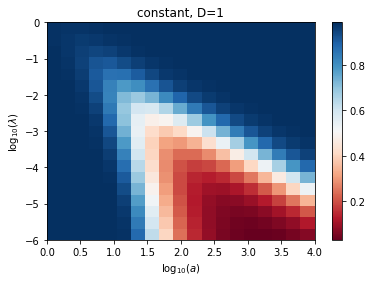

In [7]:
x, y = np.meshgrid(np.log10(a2), np.log10(l))


# fig, ax = plt.subplots(nrows=1, ncols=2)

plt.pcolor(x, y, div.T, cmap='RdBu')
plt.title('constant, D=1')
# set the limits of the plot to the limits of the data
plt.axis([x.min(), x.max(), y.min(), y.max()])
plt.colorbar()

plt.xlabel(r"$\log_{10}(a)$")
plt.ylabel(r"$\log_{10}(\lambda)$")



# c0 = ax[0].imshow(res_d, extent=[-1, 4, -6, 0])
# c1 = ax[1].imshow(res_e, extent=[-1, 4, -6, 0])




plt.savefig("large_tau_phasediagram_const.pdf", dpi=500)

<ipython-input-8-c05fe47e60af>:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(x, y, div.T, cmap='RdBu')


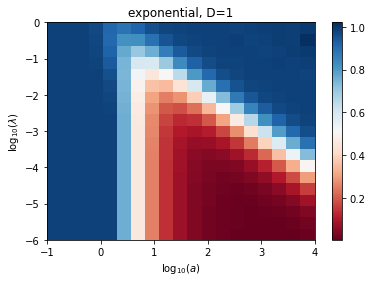

In [8]:
div = np.zeros((N,N))

for i in range(N):
    for j in range(N):
        div[i,j] = res_e[i,j] / (S_01[i,j])

x, y = np.meshgrid(np.log10(a1), np.log10(l))


# fig, ax = plt.subplots(nrows=1, ncols=2)

plt.pcolor(x, y, div.T, cmap='RdBu')
plt.title('exponential, D=1')
# set the limits of the plot to the limits of the data
plt.axis([x.min(), x.max(), y.min(), y.max()])
plt.colorbar()

plt.xlabel(r"$\log_{10}(a)$")
plt.ylabel(r"$\log_{10}(\lambda)$")



# c0 = ax[0].imshow(res_d, extent=[-1, 4, -6, 0])
# c1 = ax[1].imshow(res_e, extent=[-1, 4, -6, 0])


plt.savefig("large_tau_phasediagram_exp.pdf", dpi=500)

In [9]:
q = np.linspace(-1, 0, 100)

def dV(q):
    return q ** 3 - q 


def V(q):
    return q ** 4 / 4 - q ** 2 / 2

print(np.trapz(dV(q), q), V(0) - V(-1))

0.24997449239873482 0.25


c:\Users\LarsG\anaconda3\lib\site-packages\scipy\interpolate\_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=3,3 nx,ny=23,26 m=400 fp=0.000001 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
<ipython-input-10-f7e70849411b>:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(Xn, Yn, data1.T, cmap='RdBu')


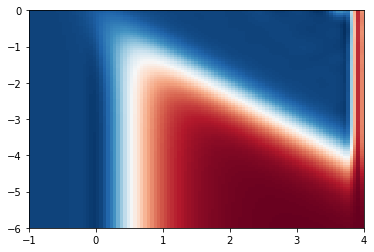

In [10]:
from scipy.interpolate import interp2d


# scipy interp. cubic
f = interp2d(x, y, div, kind='cubic')
xnew = np.linspace(np.log10(a1.min()), np.log10(a1.max()), 100)
ynew = np.linspace(np.log10(l.min()), np.log10(l.max()), 100)
data1 = f(xnew,ynew)
Xn, Yn = np.meshgrid(xnew, ynew)

plt.pcolormesh(Xn, Yn, data1.T, cmap='RdBu')

<ipython-input-11-84b99a32bc62>:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(Xn, Yn, data1.T, cmap='RdBu')


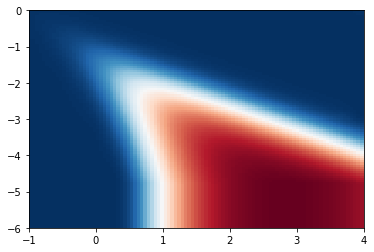

In [11]:
div = np.zeros((N,N))

x, y = np.meshgrid(np.log10(a2), np.log10(l))


for i in range(N):
    for j in range(N):
        div[i,j] = res_d[i,j] / (S_02[i,j])


# scipy interp. cubic
f = interp2d(x, y, div, kind='cubic')
xnew = np.linspace(np.log10(a1.min()), np.log10(a1.max()), 100)
ynew = np.linspace(np.log10(l.min()), np.log10(l.max()), 100)
data1 = f(xnew,ynew)
Xn, Yn = np.meshgrid(xnew, ynew)

plt.pcolormesh(Xn, Yn, data1.T, cmap='RdBu')

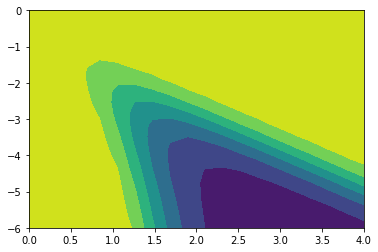

In [12]:
plt.contourf(x, y, div.T)

In [13]:
def kop(pot, l, a, D, noise, guess_size):
    def phi(x):
        if noise == "d":
            return np.cosh(x) - 1
        elif noise == "e":
            return x**2 / (2 * (1 - x**2))

    kmax = 1e-10
    Vmax = pot.max()
    while Vmax > D / 2 * kmax + l * phi(a * kmax) / kmax:
        kmax+=1e-6

    # print(l, a, D, noise)

    optk = []
    if pot[0] == 0:
        optk.append(0)
        V = pot[1:]
    else:
        V = pot
    

    K = np.linspace(start=1e-8, stop=1/a - 1e-7, num=guess_size)
    
    for x in V:
        aux = []
        if noise=="e":
            K = np.linspace(start=1e-10, stop=1/a - 1e-10, num=guess_size)
        elif noise=="d":
            if x == 0:
                K = np.zeros(guess_size)
            else:
                K = np.linspace(start=1e-15, stop=kmax , num=guess_size)
        
        for k in K:
            if x == 0:
                aux.append(0)
            else:
                p = D / 2 * k + l * phi(a * k) / k
                aux.append(np.abs(x - p))
            
        
        
        optimal_k = np.min(aux)
        
        ind = np.where(aux == optimal_k)[0]
        optk.append(K[ind][0])
    
    return optk

def integral(q, a, l, D, noise):
    def dV(q):
        return q ** 3 - q
    def ddV(q):
        return 3 * q ** 2 - 1
    
    dPot = dV(q)
    ddPot = ddV(q)
    dPot = dPot[np.where(ddPot >= 0)]
    ddPot = ddPot[np.where(ddPot >= 0)]

    #print(dPot.max(), np.cosh(1)*1/a, a)
    kopt = np.array(kop(dPot, l , a, D, noise, 10000))


    return np.trapz(kopt * ddPot, q[np.where(ddPot >= 0)]) 

In [14]:
N = 20



q = np.linspace(-1, 0, 10)



a1 = np.logspace(-1, 4, base=10, num=N)
a2 = np.logspace(0, 4, base=10, num=N)

l = np.logspace(-6, 0, base=10, num=N)

res_en = np.zeros((N, N))
res_dn = np.zeros((N, N))

S_01n = np.zeros((N, N))
S_02n = np.zeros((N, N))

for i in range(N):
    for j in range(N):
        print(a1[i], l[j])
        res_en[i, j] = integral(q=q, a=a1[i], l=l[j], D=1, noise="e")
        res_dn[i, j] = integral(q=q, a=a2[i], l=l[j], D=1, noise="d")
        S_01n[i,j] = 2 / (27 * (1 + a1[i] ** 2 * l[j]))
        S_02n[i,j] = 2 / (27 * (1 + a2[i] ** 2 * l[j]))
        # print(i)
        # print("index ", N * i +j, " a ", a[i], " l ", l[j], " g ",  S_0[i,j]," e ", res_e[i, j]," d ", res_d[i, j])

0.1 1e-06
0.1 2.06913808111479e-06
0.1 4.281332398719396e-06
0.1 8.858667904100832e-06
0.1 1.8329807108324375e-05
0.1 3.792690190732254e-05
0.1 7.847599703514606e-05
0.1 0.0001623776739188721
0.1 0.0003359818286283781
0.1 0.0006951927961775605
0.1 0.0014384498882876629
0.1 0.002976351441631316
0.1 0.00615848211066026
0.1 0.012742749857031322
0.1 0.026366508987303555
0.1 0.05455594781168514
0.1 0.11288378916846883
0.1 0.23357214690901212
0.1 0.4832930238571752
0.1 1.0
0.18329807108324356 1e-06
0.18329807108324356 2.06913808111479e-06
0.18329807108324356 4.281332398719396e-06
0.18329807108324356 8.858667904100832e-06
0.18329807108324356 1.8329807108324375e-05
0.18329807108324356 3.792690190732254e-05
0.18329807108324356 7.847599703514606e-05
0.18329807108324356 0.0001623776739188721
0.18329807108324356 0.0003359818286283781
0.18329807108324356 0.0006951927961775605
0.18329807108324356 0.0014384498882876629
0.18329807108324356 0.002976351441631316
0.18329807108324356 0.00615848211066026
0

In [19]:
div_d = np.zeros((N,N))
div_dn = np.zeros((N,N))
div_e = np.zeros((N,N))
div_en = np.zeros((N,N))

for i in range(N):
    for j in range(N):
        div_d[i,j] = res_d[i,j] / (S_02[i,j])
        div_dn[i,j] = res_dn[i,j] / (S_02n[i,j])
        div_e[i,j] = res_e[i,j] / (S_01[i,j])
        div_en[i,j] = res_en[i,j] / (S_01n[i,j])


Text(0.5, 0, '$\\log_{10}(a)$')

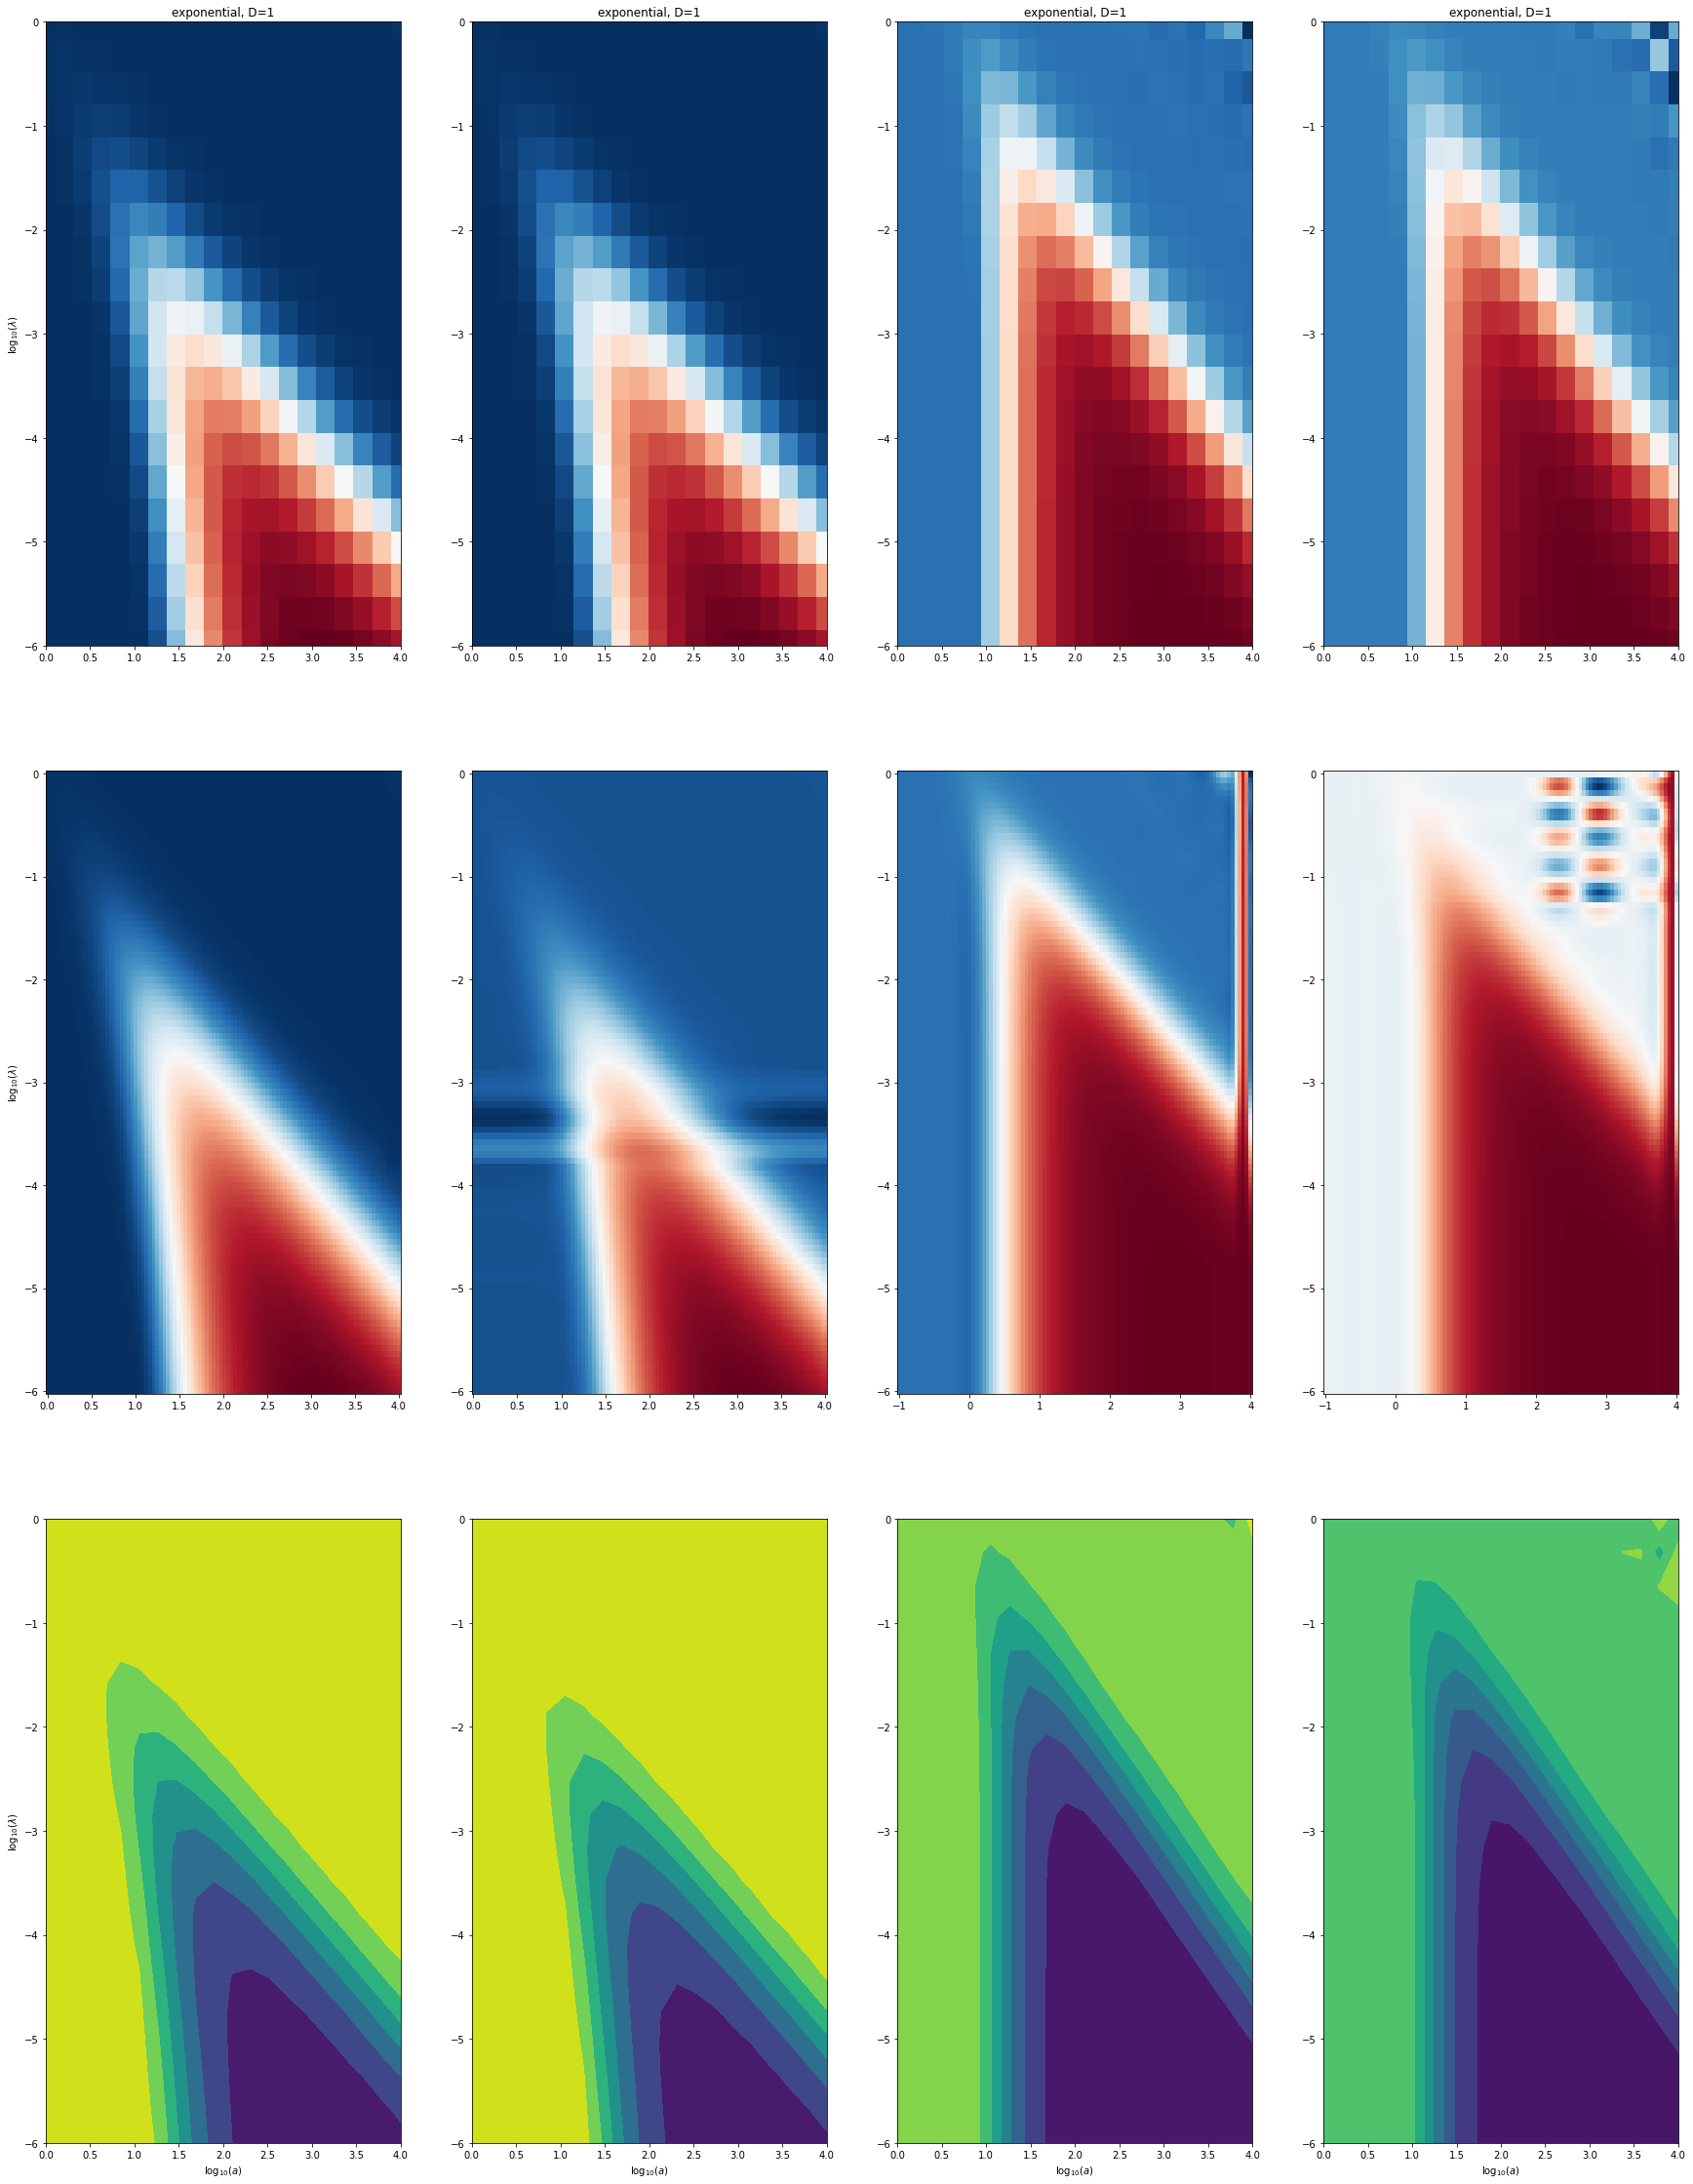

In [21]:
x2, y2 = np.meshgrid(np.log10(a2), np.log10(l))
x1, y1 = np.meshgrid(np.log10(a1), np.log10(l))

fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(30, 40))

# scipy interp. cubic
f = interp2d(x, y, div_d, kind='cubic')
xnew = np.linspace(np.log10(a2.min()), np.log10(a2.max()), 100)
ynew = np.linspace(np.log10(l.min()), np.log10(l.max()), 100)
data1 = f(xnew,ynew)
Xn, Yn = np.meshgrid(xnew, ynew)
ax[0, 0].pcolor(x, y, div_dn.T, cmap='RdBu', shading='auto')
ax[0, 0].set_title('exponential, D=1')
# set the limits of the plot to the limits of the data
ax[0, 0].axis([x.min(), x.max(), y.min(), y.max()])
#ax[0, 0].colorbar()

ax[1, 0].pcolormesh(Xn, Yn, data1.T, cmap='RdBu', shading='auto')

ax[2, 0].contourf(x, y, div_d.T)

ax[2, 0].set_xlabel(r"$\log_{10}(a)$")
ax[2, 0].set_ylabel(r"$\log_{10}(\lambda)$")
ax[0, 0].set_ylabel(r"$\log_{10}(\lambda)$")
ax[1, 0].set_ylabel(r"$\log_{10}(\lambda)$")
#################################################################################################
# scipy interp. cubic
f = interp2d(x, y, div_dn, kind='cubic')
xnew = np.linspace(np.log10(a2.min()), np.log10(a2.max()), 100)
ynew = np.linspace(np.log10(l.min()), np.log10(l.max()), 100)
data1 = f(xnew,ynew)
Xn, Yn = np.meshgrid(xnew, ynew)
ax[0, 1].pcolor(x, y, div_dn.T, cmap='RdBu', shading='auto')
ax[0, 1].set_title('exponential, D=1')
# set the limits of the plot to the limits of the data
ax[0, 1].axis([x.min(), x.max(), y.min(), y.max()])
#ax[0, 1].colorbar()

ax[1, 1].pcolormesh(Xn, Yn, data1.T, cmap='RdBu', shading='auto')

ax[2, 1].contourf(x, y, div_dn.T)

ax[2, 1].set_xlabel(r"$\log_{10}(a)$")

#################################################################################################

# scipy interp. cubic
f = interp2d(x, y, div_e, kind='cubic')
xnew = np.linspace(np.log10(a1.min()), np.log10(a1.max()), 100)
ynew = np.linspace(np.log10(l.min()), np.log10(l.max()), 100)
data1 = f(xnew,ynew)
Xn, Yn = np.meshgrid(xnew, ynew)
ax[0, 2].pcolor(x, y, div_e.T, cmap='RdBu', shading='auto')
ax[0, 2].set_title('exponential, D=1')
# set the limits of the plot to the limits of the data
ax[0, 2].axis([x.min(), x.max(), y.min(), y.max()])
#ax[0, 2].colorbar()

ax[1, 2].pcolormesh(Xn, Yn, data1.T, cmap='RdBu', shading='auto')

ax[2, 2].contourf(x, y, div_e.T)

ax[2, 2].set_xlabel(r"$\log_{10}(a)$")

#################################################################################################

# scipy interp. cubic
f = interp2d(x, y, div_en, kind='cubic')
xnew = np.linspace(np.log10(a1.min()), np.log10(a1.max()), 100)
ynew = np.linspace(np.log10(l.min()), np.log10(l.max()), 100)
data1 = f(xnew,ynew)
Xn, Yn = np.meshgrid(xnew, ynew)
ax[0, 3].pcolor(x, y, div_en.T, cmap='RdBu', shading='auto')
ax[0, 3].set_title('exponential, D=1')
# set the limits of the plot to the limits of the data
ax[0, 3].axis([x.min(), x.max(), y.min(), y.max()])
#ax[0, 3].colorbar()

ax[1, 3].pcolormesh(Xn, Yn, data1.T, cmap='RdBu', shading='auto')

ax[2, 3].contourf(x, y, div_en.T)

ax[2, 3].set_xlabel(r"$\log_{10}(a)$")
#################################################################################################